# Intro

In this notebook I implement Model Stacking with the [Titanic Dataset](https://www.kaggle.com/c/titanic). 

First I build a base classification composed of several different classification algorithms. For each base classifier I make predictions using (stratisfied) Kfold. I take a look how a simple blend with majority voring would work on that stage.

Second, I use the predictions with and without the initial features to feed a Neuro Network. 

# Setup

In [5]:
import pandas as pd
import numpy as np

# For the base classifiers
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

# Parameter Scaling
from sklearn.preprocessing import MinMaxScaler

# For the ANN
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# For Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# For Evaluation
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [6]:
# The Train and Test Data has been preprared so that they contain only numeric data from preselected features 
df_train = pd.read_csv('train_clean.csv')
df_test = pd.read_csv('test_clean.csv')
df_train.shape, df_test.shape

((891, 12), (418, 11))

In [7]:
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Deck,Title
0,0,3,0,2,1,0,0,0,1,0,8,1
1,1,1,1,5,1,0,3,1,1,0,3,3
2,1,3,1,3,0,0,0,0,0,1,8,2
3,1,1,1,5,1,0,3,0,1,0,3,3
4,0,3,0,5,0,0,1,0,0,1,8,1


# Model Stacking

## Classifier Base Level

In [8]:
# separate the target
y_train = df_train.Survived
df_train.drop(columns='Survived', inplace=True)

In [9]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]
SEED = 0
NFOLDS = 5

kf = KFold(n_splits=NFOLDS, random_state=SEED)
skf = StratifiedKFold(n_splits=NFOLDS, random_state=SEED)

c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [10]:
# Class Extensions
class SklearnHelper():
    def __init__(self, clf, seed=0, params=None):
        params['random_state']= seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.model = self.clf.fit(x_train, y_train)
        try:
            self.feature_importance = self.model.feature_importances_
        except:
            print('The Classifier has no attribute feature_importances_')
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)

In [11]:
# Out-Of-Fold Predictions

def get_oof(clf, x_train, y_train, x_test):
    K = len(set(y_train))
    oof_train = np.zeros((ntrain, K))
    oof_test = np.zeros((ntest, K))
    oof_test_kf = np.empty((NFOLDS, ntest, K))
    
    for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
        x_tr, x_val = x_train[train_index], x_train[test_index]
        y_tr, y_val = y_train[train_index], y_train[test_index]
        
        clf.train(x_tr, y_tr)
        
        ''' 
        I will fill the train predictions with predictions not from the current kfold train set,
        but from the kfold test set
        
        Furthermore, the blending can be made using probabilities or predictions. Here, i will 
        use probabilities'''
        #oof_train[test_index] = clf.predict(x_val)
        oof_train[test_index] = clf.predict_proba(x_val)
        
        # Stratified Prediction for the test set
        #oof_test_kf[i, :] = clf.predict(x_test)
        oof_test_kf[i, :, :] = clf.predict_proba(x_test)
        
    oof_test[:] = oof_test_kf.mean(axis=0)
    
    return oof_train, oof_test 
    #oof_train.reshape(-1, 1), oof_test.reshape(-1, 1) 

In [12]:
# Setting Up Parameters

# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    # 'verbose': 2
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 100,
    'learning_rate' : 0.75
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
    # 'verbose': 100,
    'max_iter': 100,
    'probability': True
    }

# LGB
lgb_params = {
    'num_leaves': 20, 
    'objective': 'binary',
    'max_depth': 20,
    'learning_rate': .01,
    'max_bin': 100,
    'scale_pos_weight': 5,
    'metrix': 'auc',
    #  'verbose': 1,
    #  'device': 'gpu' # look at https://stackoverflow.com/questions/49606886/installing-gpu-support-for-lightgbm-on-google-collab
        }

# Logistic Regression
lreg_params = {
    'class_weight': 'balanced',
    'penalty': 'l2',
    'n_jobs': -1,
}

In [13]:
# Create Objects for each model
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)
lgbm = SklearnHelper(clf=lgb.LGBMClassifier, seed=SEED, params=lgb_params)
lreg = SklearnHelper(clf=LogisticRegression, seed=SEED, params=lreg_params)

In [14]:
# Numpy Arrays out of the DFs
x_train = df_train.values
x_test = df_test.values
y_train = y_train.values

In [15]:
np.shape(y_train), np.shape(x_train), np.shape(x_test)

((891,), (891, 11), (418, 11))

## ANN Base Level

In [16]:
# ANN Architecture
N, D = x_train.shape

i = Input(shape=(D,))
x = BatchNormalization()(i)
x = Dense(500, activation='relu')(x)
x = Dropout(rate =0.2)(x)
x = BatchNormalization()(x)
x = Dense(300, activation='tanh')(x)
x = Dropout(rate =0.2)(x)
x = BatchNormalization()(x)
x = Dense(300, activation='relu')(x)
x = Dropout(rate =0.2)(x)
x = BatchNormalization()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(rate =0.2)(x)
x = Dense(1, activation='sigmoid') (x)

model_base = Model(i, x)

In [17]:
# Compile the model 
model_base.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [18]:
r = model_base.fit(x=x_train, y=y_train, epochs=200)

Train on 891 samples
Epoch 1/200
891/891 [==============================] - 1s 2ms/sample - loss: 0.5710 - accuracy: 0.7565
Epoch 2/200
891/891 [==============================] - 0s 240us/sample - loss: 0.4851 - accuracy: 0.7868
Epoch 3/200
891/891 [==============================] - 0s 198us/sample - loss: 0.4954 - accuracy: 0.7935
Epoch 4/200
891/891 [==============================] - 0s 201us/sample - loss: 0.4919 - accuracy: 0.7890
Epoch 5/200
891/891 [==============================] - 0s 201us/sample - loss: 0.4631 - accuracy: 0.8092
Epoch 6/200
891/891 [==============================] - 0s 219us/sample - loss: 0.4447 - accuracy: 0.8182
Epoch 7/200
891/891 [==============================] - 0s 143us/sample - loss: 0.4503 - accuracy: 0.8137
Epoch 8/200
891/891 [==============================] - 0s 146us/sample - loss: 0.4301 - accuracy: 0.8260
Epoch 9/200
891/891 [==============================] - 0s 157us/sample - loss: 0.4188 - accuracy: 0.8249
Epoch 10/200
891/891 [==============

891/891 [==============================] - 0s 233us/sample - loss: 0.3216 - accuracy: 0.8799
Epoch 78/200
891/891 [==============================] - 0s 222us/sample - loss: 0.3210 - accuracy: 0.8552
Epoch 79/200
891/891 [==============================] - 0s 237us/sample - loss: 0.3174 - accuracy: 0.8653
Epoch 80/200
891/891 [==============================] - 0s 242us/sample - loss: 0.3159 - accuracy: 0.8597
Epoch 81/200
891/891 [==============================] - 0s 243us/sample - loss: 0.3198 - accuracy: 0.8642
Epoch 82/200
891/891 [==============================] - 0s 259us/sample - loss: 0.3137 - accuracy: 0.8765
Epoch 83/200
891/891 [==============================] - 0s 236us/sample - loss: 0.3099 - accuracy: 0.8687
Epoch 84/200
891/891 [==============================] - 0s 237us/sample - loss: 0.3053 - accuracy: 0.8687
Epoch 85/200
891/891 [==============================] - 0s 225us/sample - loss: 0.3118 - accuracy: 0.8631
Epoch 86/200
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 223us/sample - loss: 0.2789 - accuracy: 0.8889
Epoch 154/200
891/891 [==============================] - 0s 219us/sample - loss: 0.2953 - accuracy: 0.8777
Epoch 155/200
891/891 [==============================] - 0s 238us/sample - loss: 0.2875 - accuracy: 0.8777
Epoch 156/200
891/891 [==============================] - 0s 223us/sample - loss: 0.2802 - accuracy: 0.8833
Epoch 157/200
891/891 [==============================] - 0s 221us/sample - loss: 0.2832 - accuracy: 0.8878
Epoch 158/200
891/891 [==============================] - 0s 260us/sample - loss: 0.2732 - accuracy: 0.8866
Epoch 159/200
891/891 [==============================] - 0s 212us/sample - loss: 0.2807 - accuracy: 0.8855 - loss: 0.2557 - accuracy: 0.
Epoch 160/200
891/891 [==============================] - 0s 218us/sample - loss: 0.2935 - accuracy: 0.8844
Epoch 161/200
891/891 [==============================] - 0s 210us/sample - loss: 0.2832 - accuracy: 0.8777
Epoch 162/200
891/891

In [19]:
def get_ann_base(model, x_train, x_test):
    
    # For the Train Base Predictions
    ann_base_train = model_base.predict(x_train.astype('float32'))
    ann_base_train_pred = np.zeros(shape=(x_train.shape[0],2))
    for i in range(x_train.shape[0]):
        ann_base_train_pred[i,1] = ann_base_train[i]
        ann_base_train_pred[i,0] = 1 - ann_base_train[i]
        
    # For the Test Base Predictions
    ann_base_test = model_base.predict(x_test.astype('float32'))
    ann_base_test_pred = np.zeros(shape=(x_test.shape[0],2))
    for i in range(x_test.shape[0]):
        ann_base_test_pred[i,1] = ann_base_test[i]
        ann_base_test_pred[i,0] = 1 - ann_base_test[i]
    
    return ann_base_train_pred, ann_base_test_pred

## Output First Level

In [20]:
# Support Vector Classifier
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

 # LGBMClassifier 
lgb_oof_train, lgb_oof_test = get_oof(lgbm, x_train, y_train, x_test)

# Random Forest
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)

# AdaBoost 
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)

# Logistic Regression
lr_oof_train, lr_oof_test = get_oof(lreg, x_train, y_train, x_test)

# ANN
ann_oof_train, ann_oof_test = get_ann_base(model_base, x_train, x_test)

c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_


c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\ensemble\_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\ensemble\_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\ensemble\_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
c:\users\anspa\anaconda3\envs\tf20\lib\site-packages\sklearn\ensemble\_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_
The Classifier has no attribute feature_importances_


In [21]:
## Check the correlation of the outputs
cols = df_train.columns
cols

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked',
       'relatives', 'not_alone', 'Deck', 'Title'],
      dtype='object')

In [22]:
# First Output DataFrame to explore correlation
base_predictions = np.concatenate((y_train.reshape(-1, 1), svc_oof_train, lgb_oof_train,
                                   rf_oof_train, ada_oof_train, lr_oof_train, ann_oof_train), axis=1)

# Turn into DataFrame
base_predictions = pd.DataFrame(base_predictions, columns=['Y_true', 'Y_SVC_0', 'Y_SVC_1',
                                                           'Y_LGB_0', 'Y_LGB_1',
                                                           'Y_RF_0', 'Y_RF_1',
                                                           'Y_ADA_0', 'Y_ADA_1',
                                                           'Y_LR_0', 'Y_LR_1',
                                                           'Y_ANN_0', 'Y_ANN_1'])

# Save them
base_predictions.to_csv('base_predictions_proba.csv', index=False)

In [23]:
base_predictions

,Y_true,Y_SVC_0,Y_SVC_1,Y_LGB_0,Y_LGB_1,Y_RF_0,Y_RF_1,Y_ADA_0,Y_ADA_1,Y_LR_0,Y_LR_1,Y_ANN_0,Y_ANN_1
0,0.0,0.340082,0.659918,0.668555,0.331445,0.826017,0.173983,0.508701,0.491299,0.832737,0.167263,0.466058,0.533942
1,1.0,0.216633,0.783367,0.230659,0.769341,0.014573,0.985427,0.488628,0.511372,0.032181,0.967819,0.000010,0.999990
2,1.0,0.165986,0.834014,0.378259,0.621741,0.504213,0.495787,0.498321,0.501679,0.377485,0.622515,0.194340,0.805660
3,1.0,0.233538,0.766462,0.231609,0.768391,0.024521,0.975479,0.490233,0.509767,0.039470,0.960530,0.001750,0.998250
4,0.0,0.317441,0.682559,0.711761,0.288239,0.895668,0.104332,0.508568,0.491432,0.874321,0.125679,0.925353,0.074647
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.0,0.184227,0.815773,0.303908,0.696092,0.883296,0.116704,0.503322,0.496678,0.293132,0.706868,0.999330,0.000670
887,1.0,0.408531,0.591469,0.248774,0.751226,0.075369,0.924631,0.490185,0.509815,0.049462,0.950538,0.001032,0.998968
888,0.0,0.094305,0.905695,0.278182,0.721818,0.588961,0.411039,0.498941,0.501059,0.439854,0.560146,0.959601,0.040399
889,1.0,0.500000,0.500000,0.365597,0.634403,0.473854,0.526146,0.502154,0.497846,0.422968,0.577032,0.078731,0.921269


In [31]:
base_predictions_short = [var for var in base_predictions.columns if var.endswith('1')]

In [33]:
corr_base_predictions = base_predictions[['Y_true'] + base_predictions_short].corr()
corr_base_predictions

,Y_true,Y_SVC_1,Y_LGB_1,Y_RF_1,Y_ADA_1,Y_LR_1,Y_ANN_1
Y_true,1.000000,0.349573,0.603919,0.742710,0.400992,0.623009,0.855044
Y_SVC_1,0.349573,1.000000,0.515155,0.513929,0.567076,0.537090,0.442680
Y_LGB_1,0.603919,0.515155,1.000000,0.876544,0.527472,0.896313,0.752323
Y_RF_1,0.742710,0.513929,0.876544,1.000000,0.569878,0.913430,0.876846
Y_ADA_1,0.400992,0.567076,0.527472,0.569878,1.000000,0.567239,0.482954
Y_LR_1,0.623009,0.537090,0.896313,0.913430,0.567239,1.000000,0.746902
Y_ANN_1,0.855044,0.442680,0.752323,0.876846,0.482954,0.746902,1.000000


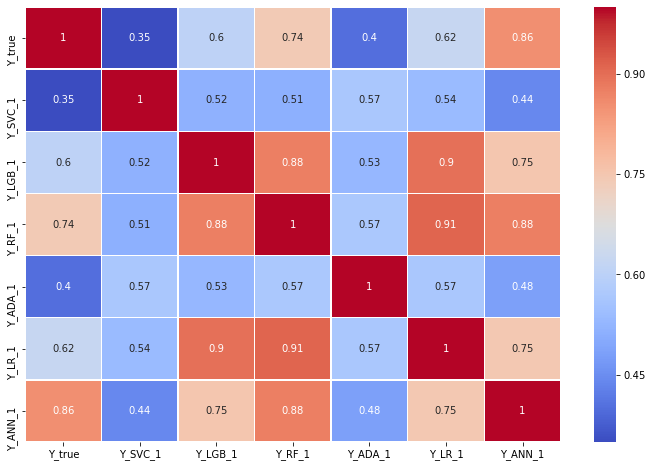

In [25]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_base_predictions, annot=True, linewidths=.5, ax=ax, cmap='coolwarm')

# Blend  - democracy voting

In [74]:
base_predictions_yhat = base_predictions[base_predictions_short].copy()
for var in base_predictions_yhat.columns:
    for i in range(len(base_predictions_yhat[var])):
        if base_predictions_yhat[var][i] > 0.5:
            base_predictions_yhat[var][i] = int(1)
        else:
            base_predictions_yhat[var][i] = int(0)

In [81]:
# Blend the predictions by mijority voting
base_blend_yhat = np.round((base_predictions_yhat.sum(axis=1) / 6), decimals=0)

In [99]:
print('Train Test Accuaracy {}'.format(round(accuracy_score(base_predictions.Y_true, base_blend_yhat), 2)))
print()
print('Confusion Matrix for democracy voting')
print(confusion_matrix(base_predictions.Y_true, base_blend_yhat))
print('')

Train Test Accuaracy 0.84

Confusion Matrix for democracy voting
[[478  71]
 [ 68 274]]



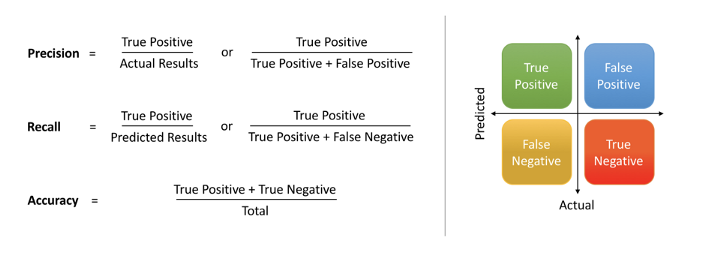

In [100]:
from IPython.display import Image
Image("../Precision&Recall.png")

In [101]:
target_names = ['Survived', 'Not-Survived']
print(classification_report(base_predictions.Y_true, base_blend_yhat, target_names=target_names))

              precision    recall  f1-score   support

    Survived       0.88      0.87      0.87       549
Not-Survived       0.79      0.80      0.80       342

    accuracy                           0.84       891
   macro avg       0.83      0.84      0.84       891
weighted avg       0.84      0.84      0.84       891



In [96]:
for var in base_predictions_yhat.columns:
    print('Train Test Accuaracy for {}'.format(var))
    print(round(accuracy_score(base_predictions.Y_true, base_predictions_yhat[var]), 2))
    print('')
    print('Confusion Matrix for {}'.format(var))
    print(confusion_matrix(base_predictions.Y_true, base_predictions_yhat[var]))
    print('')

Train Test Accuaracy for Y_SVC_1
0.41

Confusion Matrix for Y_SVC_1
[[ 30 519]
 [  9 333]]

Train Test Accuaracy for Y_LGB_1
0.78

Confusion Matrix for Y_LGB_1
[[398 151]
 [ 47 295]]

Train Test Accuaracy for Y_RF_1
0.87

Confusion Matrix for Y_RF_1
[[505  44]
 [ 76 266]]

Train Test Accuaracy for Y_ADA_1
0.82

Confusion Matrix for Y_ADA_1
[[471  78]
 [ 83 259]]

Train Test Accuaracy for Y_LR_1
0.78

Confusion Matrix for Y_LR_1
[[432 117]
 [ 75 267]]

Train Test Accuaracy for Y_ANN_1
0.91

Confusion Matrix for Y_ANN_1
[[525  24]
 [ 57 285]]



# ANN for the final predictions


## Using only the base_models predictions

In [102]:
def ANN_function(X):
    N, D = X.shape
    
    i = Input(shape=(D,))
    x = BatchNormalization()(i)
    x = Dense(units=1000, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=300, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=200, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=200, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(i,x)
    return model

In [120]:
X_base = base_predictions[base_predictions_short].values
model = ANN_function(X)

In [118]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 6)                 24        
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              7000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 300)               300300    
_________________________________________________________________
dropout_9 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 200)               6020

In [119]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r = model.fit(x = X_base, y = y_train, epochs=100)

Train on 891 samples
Epoch 1/100
891/891 [==============================] - 1s 953us/sample - loss: 0.3361 - accuracy: 0.8833
Epoch 2/100
891/891 [==============================] - 0s 215us/sample - loss: 0.2389 - accuracy: 0.9057
Epoch 3/100
891/891 [==============================] - 0s 216us/sample - loss: 0.2683 - accuracy: 0.9068
Epoch 4/100
891/891 [==============================] - 0s 212us/sample - loss: 0.2555 - accuracy: 0.9113
Epoch 5/100
891/891 [==============================] - 0s 262us/sample - loss: 0.2220 - accuracy: 0.9068
Epoch 6/100
891/891 [==============================] - 0s 308us/sample - loss: 0.2408 - accuracy: 0.9158
Epoch 7/100
891/891 [==============================] - 0s 269us/sample - loss: 0.2215 - accuracy: 0.9147
Epoch 8/100
891/891 [==============================] - 0s 268us/sample - loss: 0.2179 - accuracy: 0.9181
Epoch 9/100
891/891 [==============================] - 0s 264us/sample - loss: 0.2254 - accuracy: 0.9136
Epoch 10/100
891/891 [============

891/891 [==============================] - 0s 234us/sample - loss: 0.2109 - accuracy: 0.9293
Epoch 78/100
891/891 [==============================] - 0s 235us/sample - loss: 0.2036 - accuracy: 0.9259
Epoch 79/100
891/891 [==============================] - 0s 242us/sample - loss: 0.2027 - accuracy: 0.9181
Epoch 80/100
891/891 [==============================] - 0s 221us/sample - loss: 0.2025 - accuracy: 0.9226
Epoch 81/100
891/891 [==============================] - 0s 233us/sample - loss: 0.2178 - accuracy: 0.9214
Epoch 82/100
891/891 [==============================] - 0s 226us/sample - loss: 0.2123 - accuracy: 0.9214
Epoch 83/100
891/891 [==============================] - 0s 345us/sample - loss: 0.1970 - accuracy: 0.9237
Epoch 84/100
891/891 [==============================] - 0s 244us/sample - loss: 0.1859 - accuracy: 0.9237
Epoch 85/100
891/891 [==============================] - 0s 244us/sample - loss: 0.1892 - accuracy: 0.9226
Epoch 86/100
891/891 [==============================] - 0s 

## ANN concatenated base model predictions with scaled train set features

So far the best result on this dataset - 78% accuracy

In [114]:
sc = MinMaxScaler()
sc.fit(df_train)
train_scaled = sc.transform(df_train)

In [116]:
base_predictions[base_predictions_short]

,Y_SVC_1,Y_LGB_1,Y_RF_1,Y_ADA_1,Y_LR_1,Y_ANN_1
0,0.659918,0.331445,0.173983,0.491299,0.167263,0.533942
1,0.783367,0.769341,0.985427,0.511372,0.967819,0.999990
2,0.834014,0.621741,0.495787,0.501679,0.622515,0.805660
3,0.766462,0.768391,0.975479,0.509767,0.960530,0.998250
4,0.682559,0.288239,0.104332,0.491432,0.125679,0.074647
...,...,...,...,...,...,...
886,0.815773,0.696092,0.116704,0.496678,0.706868,0.000670
887,0.591469,0.751226,0.924631,0.509815,0.950538,0.998968
888,0.905695,0.721818,0.411039,0.501059,0.560146,0.040399
889,0.500000,0.634403,0.526146,0.497846,0.577032,0.921269


In [121]:
X_base

array([[0.65991835, 0.331445  , 0.17398266, 0.49129893, 0.16726289,
        0.53394163],
       [0.78336675, 0.76934055, 0.98542697, 0.51137233, 0.96781868,
        0.99999022],
       [0.8340139 , 0.62174074, 0.49578651, 0.50167927, 0.62251548,
        0.80565971],
       ...,
       [0.90569474, 0.72181833, 0.4110385 , 0.50105892, 0.56014636,
        0.04039919],
       [0.5       , 0.63440343, 0.5261458 , 0.49784582, 0.57703218,
        0.92126888],
       [0.82658789, 0.32059793, 0.11919454, 0.4934285 , 0.17829354,
        0.20556907]])

In [122]:
# Defining the X_train
X_train_Base_and_features = np.concatenate((train_scaled, X_base), axis=1)
np.shape(X_train_Base_and_features)

(891, 17)

In [123]:
model2 = ANN_function(X_train_Base_and_features)
# model2.summary()

In [124]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
r = model2.fit(x = X_train_Base_and_features, y = y_train, epochs=100)

Train on 891 samples
Epoch 1/100
891/891 [==============================] - 1s 929us/sample - loss: 0.3865 - accuracy: 0.8496
Epoch 2/100
891/891 [==============================] - 0s 255us/sample - loss: 0.2635 - accuracy: 0.9057
Epoch 3/100
891/891 [==============================] - 0s 254us/sample - loss: 0.2531 - accuracy: 0.9035
Epoch 4/100
891/891 [==============================] - 0s 247us/sample - loss: 0.2640 - accuracy: 0.9068
Epoch 5/100
891/891 [==============================] - 0s 253us/sample - loss: 0.2695 - accuracy: 0.9102
Epoch 6/100
891/891 [==============================] - 0s 303us/sample - loss: 0.2263 - accuracy: 0.9113
Epoch 7/100
891/891 [==============================] - 0s 373us/sample - loss: 0.2301 - accuracy: 0.9057
Epoch 8/100
891/891 [==============================] - 0s 245us/sample - loss: 0.2216 - accuracy: 0.9169
Epoch 9/100
891/891 [==============================] - 0s 259us/sample - loss: 0.2366 - accuracy: 0.9091
Epoch 10/100
891/891 [============

891/891 [==============================] - 0s 232us/sample - loss: 0.1745 - accuracy: 0.9282
Epoch 79/100
891/891 [==============================] - 0s 310us/sample - loss: 0.1819 - accuracy: 0.9282
Epoch 80/100
891/891 [==============================] - 0s 255us/sample - loss: 0.1632 - accuracy: 0.9293
Epoch 81/100
891/891 [==============================] - 0s 233us/sample - loss: 0.1757 - accuracy: 0.9270
Epoch 82/100
891/891 [==============================] - 0s 223us/sample - loss: 0.1927 - accuracy: 0.9214
Epoch 83/100
891/891 [==============================] - 0s 203us/sample - loss: 0.1766 - accuracy: 0.9304
Epoch 84/100
891/891 [==============================] - 0s 207us/sample - loss: 0.1774 - accuracy: 0.9259
Epoch 85/100
891/891 [==============================] - 0s 228us/sample - loss: 0.1864 - accuracy: 0.9214
Epoch 86/100
891/891 [==============================] - 0s 292us/sample - loss: 0.1627 - accuracy: 0.9349
Epoch 87/100
891/891 [==============================] - 0s 

# Predicting the Test Set

In [136]:
# First Output DataFrame to explore correlation
base_predictions_test = np.concatenate((svc_oof_test, lgb_oof_test,
                                   rf_oof_test, ada_oof_test, lr_oof_test, ann_oof_test), axis=1)

# Turn into DataFrame
base_predictions_test = pd.DataFrame(base_predictions_test, columns=['Y_SVC_0', 'Y_SVC_1',
                                                           'Y_LGB_0', 'Y_LGB_1',
                                                           'Y_RF_0', 'Y_RF_1',
                                                           'Y_ADA_0', 'Y_ADA_1',
                                                           'Y_LR_0', 'Y_LR_1',
                                                           'Y_ANN_0', 'Y_ANN_1'])

# Get only the probabilities for a 1
base_predictions_test = base_predictions_test[base_predictions_short]

# Scale the df_test
test_scaled = pd.DataFrame(sc.transform(df_test), columns=df_test.columns)

# Concatenate df_test and the base predictions
X_test_base_predictions = pd.concat((test_scaled, base_predictions_test), axis=1)

In [138]:
test_pred = model2.predict(X_test_base_predictions)

In [139]:
np.shape(test_pred)

(418, 1)

In [140]:
# Convert the probabilities:
predictions_test = np.zeros(test_pred.shape[0])
for i in range(len(predictions_test)):
    if test_pred[i] > 0.5:
        predictions_test[i] = 1

# Make a Dataframe
predictions_test = pd.DataFrame(predictions_test, columns=['Survived'], dtype=int)

## Submission and Result

In [143]:
test_id = pd.read_csv('test.csv').PassengerId
test_id = pd.DataFrame(test_id, columns=['PassengerId'])

In [144]:
submission = pd.concat([test_id, predictions_test], axis=1)  

In [145]:
submission.to_csv('Prediction_Stacking_v5.csv', index=False)

The public score achieve is 0.78468

For a first ensamble model from this complexity is not bad, i think. What would be definetely better is to preevaluate the models using separated validation set or another technique such as cross-validation